# TASK 2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

import tqdm

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(1)
import math,random

### Prepare data 

In [2]:
import os
import pandas as pd
from nltk.probability import FreqDist
import re

# READ DATA
parentdir = "../propaganda_dataset_v2"
train_file = "propaganda_train.tsv"
test_file = "propaganda_val.tsv"

train_path = os.path.join(parentdir,train_file)
test_path = os.path.join(parentdir,test_file)

# read csv and save in a dataframe
train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
test_df=pd.read_csv(test_path,delimiter="\t",quotechar='|')
all_data_df = pd.concat([train_df, test_df])


# DATA PREPROCESSING

# remove not propaganda samples
train_df = train_df[train_df["label"] != "not_propaganda"]
test_df = test_df[test_df["label"] != "not_propaganda"]
all_data_df = all_data_df[all_data_df["label"] != "not_propaganda"]

# assign each technique an label and save in a dictionary
cls_fq = FreqDist(train_df["label"])
techniques = {item: idx for idx, item in enumerate(list(cls_fq.keys()))} 

# label to index
label_to_idx = {"S": 0, "O": 1, "B": 2, "I": 3, "E": 4}

def find_snippet(sample): # Preprocess the text in data (Copied from TASK 1. METHOD 3.)
    return re.findall(r'BOS(.*?)EOS', ' '.join(re.findall(r'\w+', sample)))[0].split()

def preprocessed_text(sample):
    filtered = re.findall(r'\w+', sample)
    removed = [word for word in filtered if word != "bos" and word != "eos"]
    return ["__START"]+removed+["__END"]

def preprocess_label(label):
    return techniques[label]

def NBOI_labelling(sample):
    filtered = re.findall(r'\w+', sample)
    sequence_label = []
    inside_flag = False
    for prev, token in zip(["-100"]+filtered, filtered):
        if token == "BOS":
            #label = "B"
            inside_flag = True
        elif token == "EOS":
            #label = "I"
            inside_flag = False
        else:
            if inside_flag: 
                if prev == "BOS": label="B"
                else: label = "I"
            else: label = "O"
            sequence_label.append(label)    

    return ["S"]+sequence_label+["E"]

def NBOI_index(sample):
    return [label_to_idx[label] for label in sample]

def word_to_char(sample):
    return [c for c in ''.join(sample)]
                    
def preprocess_dataframe(data_df):
    df = data_df[['label','tagged_in_context']]  # copy dataframe
    df['label_idx'] = data_df['label'].apply(preprocess_label) # process label
    df['snippet'] = data_df['tagged_in_context'].apply(find_snippet) # find snippet in sample text
    df['NOBI'] = data_df['tagged_in_context'].apply(NBOI_labelling) # get NOBI sequence labelling
    df['NOBI_idx'] = df['NOBI'].apply(NBOI_index) # get NOBI sequence labelling
    
    df['sample_word'] = data_df['tagged_in_context'].apply(str.lower)
    df['sample_word'] = df['sample_word'].apply(preprocessed_text) # process sample text
    #df['sample_char'] = df['sample_word'].apply(word_to_char) # process sample text
    
    return df

In [3]:
# Create and split data

train_df_prep = preprocess_dataframe(train_df)
test_df_prep = preprocess_dataframe(test_df)
all_df_prep = preprocess_dataframe(all_data_df)



In [4]:
# Encode text (word level) - transfer text to values

# get all vocabs
vocab = set([word for phrase in all_df_prep['sample_word'] for word in phrase])
# get index for each vocab
word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}
# reverse index
idx_to_word = {idx: word for idx, word in enumerate(vocab, 1)}

MAX_SAMPLE_LEN_word = max(all_df_prep['sample_word'].apply(len))

def encode_phrase(phrase):
    return [word_to_idx[word] for word in phrase]

# encode text data
train_df_prep['sample_word_idx'] = train_df_prep['sample_word'].apply(encode_phrase)
test_df_prep['sample_word_idx'] = test_df_prep['sample_word'].apply(encode_phrase)



In [5]:
train_df_prep

,label,tagged_in_context,label_idx,snippet,NOBI,NOBI_idx,sample_word,sample_word_idx
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",0,"[American, people]","[S, O, O, O, O, O, B, I, O, O, O, O, O, O, O, ...","[0, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, ...","[__START, the, obama, administration, misled, ...","[777, 5694, 4546, 3636, 6088, 5694, 4172, 2699..."
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",1,[annihilated],"[S, O, B, O, O, O, O, O, O, O, O, O, O, O, E]","[0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4]","[__START, hitler, annihilated, 400, 000, germa...","[777, 6226, 4029, 1913, 275, 3169, 3638, 1878,..."
8,doubt,"As noted above, at this point literally every ...",2,"[so, called, evidence]","[S, O, O, O, O, O, O, O, O, O, O, B, I, I, O, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, ...","[__START, as, noted, above, at, this, point, l...","[777, 6372, 2265, 443, 2201, 147, 2482, 3899, ..."
10,"name_calling,labeling",His account was suspended for violating Twitte...,3,"[hateful, conduct]","[S, O, O, O, O, O, O, O, O, O, O, O, B, I, O, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, ...","[__START, his, account, was, suspended, for, v...","[777, 964, 4538, 1044, 1351, 2346, 6637, 4805,..."
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,4,"[point, to, Iran, s, positioning, itself, for,...","[S, O, O, O, O, O, O, O, O, O, B, I, I, I, I, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, ...","[__START, a, couple, of, seemingly, unrelated,...","[777, 2545, 3178, 2958, 5455, 133, 711, 147, 5..."
...,...,...,...,...,...,...,...,...
2549,repetition,You might think that would have cured him of f...,5,[Nazi],"[S, O, O, O, O, O, O, O, O, O, O, B, O, E]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4]","[__START, you, might, think, that, would, have...","[777, 3093, 6074, 539, 6067, 5921, 4940, 4197,..."
2551,"exaggeration,minimisation",“I would like to take this opportunity to make...,7,"[absolutely, no, place, for, anti, Semitism]","[S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[__START, i, would, like, to, take, this, oppo...","[777, 4031, 5921, 5459, 4435, 5978, 147, 3097,..."
2552,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...,0,"[Prosecutors, Doing, Mueller, s, Dirty, Work, ...","[S, O, O, O, O, O, O, O, O, O, O, B, I, I, I, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, ...","[__START, trump, to, jeff, sessions, put, an, ...","[777, 1998, 4435, 125, 649, 1928, 1078, 5605, ..."
2553,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...,6,"[Neither, the, Democrat, leadership, nor, the,...","[S, B, I, I, I, I, I, I, I, I, I, I, I, I, I, ...","[0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[__START, neither, the, democrat, leadership, ...","[777, 1003, 5694, 4957, 4203, 3152, 5694, 4957..."


In [6]:
new_label_to_idx = {}
tags = ["S", "O", "B", "I", "E"]

for i in range(8):
    for j in range(len(tags)):
        label = str(i)+tags[j]
        new_label_to_idx[label] = 5*i+j

new_idx_to_label = {v:k for k,v in new_label_to_idx.items()}

In [7]:
new_label_to_idx

{'0S': 0,
 '0O': 1,
 '0B': 2,
 '0I': 3,
 '0E': 4,
 '1S': 5,
 '1O': 6,
 '1B': 7,
 '1I': 8,
 '1E': 9,
 '2S': 10,
 '2O': 11,
 '2B': 12,
 '2I': 13,
 '2E': 14,
 '3S': 15,
 '3O': 16,
 '3B': 17,
 '3I': 18,
 '3E': 19,
 '4S': 20,
 '4O': 21,
 '4B': 22,
 '4I': 23,
 '4E': 24,
 '5S': 25,
 '5O': 26,
 '5B': 27,
 '5I': 28,
 '5E': 29,
 '6S': 30,
 '6O': 31,
 '6B': 32,
 '6I': 33,
 '6E': 34,
 '7S': 35,
 '7O': 36,
 '7B': 37,
 '7I': 38,
 '7E': 39}

In [8]:

def assign_new_nobi_idx(df):
    new_nobi_idx = []
    for label,nobis in zip(df["label_idx"].values, df["NOBI"].values):
        inner_lst = []
        #print(label, nobis)
        for idx in nobis:
            inner_lst.append(new_label_to_idx[str(label)+idx])

        new_nobi_idx.append(inner_lst)

    #return new_nobi_idx
    df["new_NOBI_idx"] = new_nobi_idx

assign_new_nobi_idx(train_df_prep)
assign_new_nobi_idx(test_df_prep)
assign_new_nobi_idx(all_df_prep)


In [9]:
train_df_prep

,label,tagged_in_context,label_idx,snippet,NOBI,NOBI_idx,sample_word,sample_word_idx,new_NOBI_idx
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",0,"[American, people]","[S, O, O, O, O, O, B, I, O, O, O, O, O, O, O, ...","[0, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, ...","[__START, the, obama, administration, misled, ...","[777, 5694, 4546, 3636, 6088, 5694, 4172, 2699...","[0, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, ..."
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",1,[annihilated],"[S, O, B, O, O, O, O, O, O, O, O, O, O, O, E]","[0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4]","[__START, hitler, annihilated, 400, 000, germa...","[777, 6226, 4029, 1913, 275, 3169, 3638, 1878,...","[5, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9]"
8,doubt,"As noted above, at this point literally every ...",2,"[so, called, evidence]","[S, O, O, O, O, O, O, O, O, O, O, B, I, I, O, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, ...","[__START, as, noted, above, at, this, point, l...","[777, 6372, 2265, 443, 2201, 147, 2482, 3899, ...","[10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1..."
10,"name_calling,labeling",His account was suspended for violating Twitte...,3,"[hateful, conduct]","[S, O, O, O, O, O, O, O, O, O, O, O, B, I, O, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, ...","[__START, his, account, was, suspended, for, v...","[777, 964, 4538, 1044, 1351, 2346, 6637, 4805,...","[15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,4,"[point, to, Iran, s, positioning, itself, for,...","[S, O, O, O, O, O, O, O, O, O, B, I, I, I, I, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, ...","[__START, a, couple, of, seemingly, unrelated,...","[777, 2545, 3178, 2958, 5455, 133, 711, 147, 5...","[20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 2..."
...,...,...,...,...,...,...,...,...,...
2549,repetition,You might think that would have cured him of f...,5,[Nazi],"[S, O, O, O, O, O, O, O, O, O, O, B, O, E]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4]","[__START, you, might, think, that, would, have...","[777, 3093, 6074, 539, 6067, 5921, 4940, 4197,...","[25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 2..."
2551,"exaggeration,minimisation",“I would like to take this opportunity to make...,7,"[absolutely, no, place, for, anti, Semitism]","[S, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[__START, i, would, like, to, take, this, oppo...","[777, 4031, 5921, 5459, 4435, 5978, 147, 3097,...","[35, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 3..."
2552,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...,0,"[Prosecutors, Doing, Mueller, s, Dirty, Work, ...","[S, O, O, O, O, O, O, O, O, O, O, B, I, I, I, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, ...","[__START, trump, to, jeff, sessions, put, an, ...","[777, 1998, 4435, 125, 649, 1928, 1078, 5605, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, ..."
2553,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...,6,"[Neither, the, Democrat, leadership, nor, the,...","[S, B, I, I, I, I, I, I, I, I, I, I, I, I, I, ...","[0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[__START, neither, the, democrat, leadership, ...","[777, 1003, 5694, 4957, 4203, 3152, 5694, 4957...","[30, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 3..."


## METHOD 1. LSTM Tagger

### a. Create Dataset and Dataloader

In [11]:
# Check any zero items

train_sample_word_lst = train_df_prep["sample_word_idx"].values.tolist()
train_nobi_idx_lst = train_df_prep["new_NOBI_idx"].values.tolist()

print(len(train_sample_word_lst))
print(len(train_nobi_idx_lst))

for i,(wlst,nlst) in enumerate(zip(train_sample_word_lst, train_nobi_idx_lst)):
    if wlst == [] or nlst == []: 
        print(i, train_df_prep["tagged_in_context"][i], wlst, nlst)
        train_sample_word_lst.pop(i)
        train_nobi_idx_lst.pop(i)

print(len(train_sample_word_lst))
print(len(train_nobi_idx_lst))


test_sample_word_lst = test_df_prep["sample_word_idx"].values.tolist()
test_nobi_idx_lst = test_df_prep["new_NOBI_idx"].values.tolist()
print(len(test_sample_word_lst))
print(len(test_nobi_idx_lst))


for i,(wlst,nlst) in enumerate(zip(test_sample_word_lst, test_nobi_idx_lst)):
    if wlst == [] or nlst == []: 
        print(i, test_df_prep["tagged_in_context"][i], wlst, nlst)
        test_sample_word_lst.pop(i)
        test_nobi_idx_lst.pop(i)

print(len(test_sample_word_lst))
print(len(test_nobi_idx_lst))


1291
1291
1291
1291
309
309
309
309


In [12]:
class SequenceDataset(Dataset):
    def __init__(self, samples, labels):
        self.texts = samples
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)


train_dataset = SequenceDataset(train_sample_word_lst, train_nobi_idx_lst)  # text shape = (num_sample, max_sample_len), label shape = (num_sample, 1)
test_dataset = SequenceDataset(test_sample_word_lst, test_nobi_idx_lst)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### b. Create Model

In [13]:
# Define RNN model

# 2. Model Definition
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = torch.log_softmax(tag_space, dim=1)
        return tag_scores

    def demo(self, sentence):
        snippet = []
        with torch.no_grad():
            outputs = model(sentence)
            _, predicted = torch.max(outputs.data, 1) 

            predicted_seq = [i%5 for i in predicted.tolist()]
            predicted_cls_ix = sorted(FreqDist([i//5 for i in predicted.tolist()]), key=FreqDist([i//5 for i in predicted.tolist()]).get, reverse=True)[0]
            predicted_cls = [cls for cls, idx in techniques.items() if idx == predicted_cls_ix][0]
            
            snippet = [token for token, label in zip(sentence, predicted_seq) if label == 2 or label == 3]
            joined = " ".join(snippet)
            
            print(f"Propaganda text = {sentence}")
            print(f"Predicted class = {predicted_cls}\nPredicted snippet = \"{joined}\"")


EMBEDDING_DIM = 15
VOCAB_SIZE = len(vocab) + 1
HIDDEN_DIM = 15
TAGSET_SIZE = len(new_label_to_idx)

In [14]:
# Train the model

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
EPOCHS = 100
train_losses = []
for epoch in tqdm.tqdm(range(EPOCHS)):
    train_loss = 0
    for i, (sample, label) in enumerate(train_dataset):
        model.zero_grad()
        
        tag_scores = model(sample)

        loss = loss_function(tag_scores, label)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_dataset))
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {train_loss / len(train_dataset):.4f}')

  1%|▍                                          | 1/100 [00:03<05:52,  3.56s/it]

Epoch [1/100], Loss: 2.9683


  2%|▊                                          | 2/100 [00:07<05:44,  3.52s/it]

Epoch [2/100], Loss: 2.7376


  3%|█▎                                         | 3/100 [00:10<05:35,  3.45s/it]

Epoch [3/100], Loss: 2.7018


  4%|█▋                                         | 4/100 [00:13<05:36,  3.50s/it]

Epoch [4/100], Loss: 2.6746


  5%|██▏                                        | 5/100 [00:17<05:32,  3.50s/it]

Epoch [5/100], Loss: 2.6358


  6%|██▌                                        | 6/100 [00:21<05:37,  3.59s/it]

Epoch [6/100], Loss: 2.6049


  7%|███                                        | 7/100 [00:24<05:30,  3.56s/it]

Epoch [7/100], Loss: 2.5582


  8%|███▍                                       | 8/100 [00:28<05:22,  3.50s/it]

Epoch [8/100], Loss: 2.5006


  9%|███▊                                       | 9/100 [00:31<05:16,  3.48s/it]

Epoch [9/100], Loss: 2.4418


 10%|████▏                                     | 10/100 [00:35<05:17,  3.53s/it]

Epoch [10/100], Loss: 2.3883


 11%|████▌                                     | 11/100 [00:38<05:16,  3.56s/it]

Epoch [11/100], Loss: 2.3456


 12%|█████                                     | 12/100 [00:42<05:11,  3.54s/it]

Epoch [12/100], Loss: 2.2663


 13%|█████▍                                    | 13/100 [00:45<05:03,  3.49s/it]

Epoch [13/100], Loss: 2.2000


 14%|█████▉                                    | 14/100 [00:49<05:01,  3.50s/it]

Epoch [14/100], Loss: 2.1270


 15%|██████▎                                   | 15/100 [00:52<05:03,  3.58s/it]

Epoch [15/100], Loss: 2.0517


 16%|██████▋                                   | 16/100 [00:56<04:58,  3.56s/it]

Epoch [16/100], Loss: 1.9823


 17%|███████▏                                  | 17/100 [00:59<04:52,  3.52s/it]

Epoch [17/100], Loss: 1.9191


 18%|███████▌                                  | 18/100 [01:03<04:49,  3.53s/it]

Epoch [18/100], Loss: 1.8528


 19%|███████▉                                  | 19/100 [01:06<04:44,  3.51s/it]

Epoch [19/100], Loss: 1.8908


 20%|████████▍                                 | 20/100 [01:10<04:35,  3.44s/it]

Epoch [20/100], Loss: 1.7522


 21%|████████▊                                 | 21/100 [01:13<04:36,  3.49s/it]

Epoch [21/100], Loss: 1.6908


 22%|█████████▏                                | 22/100 [01:17<04:41,  3.61s/it]

Epoch [22/100], Loss: 1.6246


 23%|█████████▋                                | 23/100 [01:21<04:33,  3.55s/it]

Epoch [23/100], Loss: 1.5671


 24%|██████████                                | 24/100 [01:24<04:28,  3.53s/it]

Epoch [24/100], Loss: 1.5202


 25%|██████████▌                               | 25/100 [01:28<04:25,  3.54s/it]

Epoch [25/100], Loss: 1.4671


 26%|██████████▉                               | 26/100 [01:31<04:23,  3.57s/it]

Epoch [26/100], Loss: 1.4156


 27%|███████████▎                              | 27/100 [01:35<04:22,  3.59s/it]

Epoch [27/100], Loss: 1.3789


 28%|███████████▊                              | 28/100 [01:38<04:15,  3.55s/it]

Epoch [28/100], Loss: 1.3160


 29%|████████████▏                             | 29/100 [01:42<04:11,  3.55s/it]

Epoch [29/100], Loss: 1.2843


 30%|████████████▌                             | 30/100 [01:45<04:05,  3.51s/it]

Epoch [30/100], Loss: 1.2704


 31%|█████████████                             | 31/100 [01:49<04:05,  3.56s/it]

Epoch [31/100], Loss: 1.2252


 32%|█████████████▍                            | 32/100 [01:53<04:04,  3.60s/it]

Epoch [32/100], Loss: 1.2051


 33%|█████████████▊                            | 33/100 [01:57<04:20,  3.88s/it]

Epoch [33/100], Loss: 1.1467


 34%|██████████████▎                           | 34/100 [02:01<04:08,  3.77s/it]

Epoch [34/100], Loss: 1.1267


 35%|██████████████▋                           | 35/100 [02:04<04:00,  3.70s/it]

Epoch [35/100], Loss: 1.0924


 36%|███████████████                           | 36/100 [02:08<03:52,  3.63s/it]

Epoch [36/100], Loss: 1.0810


 37%|███████████████▌                          | 37/100 [02:11<03:46,  3.59s/it]

Epoch [37/100], Loss: 1.0494


 38%|███████████████▉                          | 38/100 [02:15<03:40,  3.56s/it]

Epoch [38/100], Loss: 1.0287


 39%|████████████████▍                         | 39/100 [02:18<03:37,  3.56s/it]

Epoch [39/100], Loss: 1.0040


 40%|████████████████▊                         | 40/100 [02:22<03:35,  3.59s/it]

Epoch [40/100], Loss: 0.9939


 41%|█████████████████▏                        | 41/100 [02:26<03:34,  3.63s/it]

Epoch [41/100], Loss: 0.9640


 42%|█████████████████▋                        | 42/100 [02:29<03:29,  3.61s/it]

Epoch [42/100], Loss: 0.9612


 43%|██████████████████                        | 43/100 [02:33<03:23,  3.58s/it]

Epoch [43/100], Loss: 0.9501


 44%|██████████████████▍                       | 44/100 [02:36<03:19,  3.57s/it]

Epoch [44/100], Loss: 0.9285


 45%|██████████████████▉                       | 45/100 [02:40<03:16,  3.58s/it]

Epoch [45/100], Loss: 0.8967


 46%|███████████████████▎                      | 46/100 [02:43<03:12,  3.57s/it]

Epoch [46/100], Loss: 0.8720


 47%|███████████████████▋                      | 47/100 [02:47<03:09,  3.57s/it]

Epoch [47/100], Loss: 0.8673


 48%|████████████████████▏                     | 48/100 [02:51<03:10,  3.66s/it]

Epoch [48/100], Loss: 0.8634


 49%|████████████████████▌                     | 49/100 [02:55<03:05,  3.64s/it]

Epoch [49/100], Loss: 0.8397


 50%|█████████████████████                     | 50/100 [02:58<03:05,  3.70s/it]

Epoch [50/100], Loss: 0.8368


 51%|█████████████████████▍                    | 51/100 [03:02<03:01,  3.70s/it]

Epoch [51/100], Loss: 0.8236


 52%|█████████████████████▊                    | 52/100 [03:06<02:54,  3.64s/it]

Epoch [52/100], Loss: 0.8065


 53%|██████████████████████▎                   | 53/100 [03:09<02:48,  3.59s/it]

Epoch [53/100], Loss: 0.7899


 54%|██████████████████████▋                   | 54/100 [03:13<02:47,  3.63s/it]

Epoch [54/100], Loss: 0.7760


 55%|███████████████████████                   | 55/100 [03:17<02:46,  3.70s/it]

Epoch [55/100], Loss: 0.7917


 56%|███████████████████████▌                  | 56/100 [03:20<02:41,  3.67s/it]

Epoch [56/100], Loss: 0.7832


 57%|███████████████████████▉                  | 57/100 [03:25<02:48,  3.91s/it]

Epoch [57/100], Loss: 0.7459


 58%|████████████████████████▎                 | 58/100 [03:28<02:40,  3.83s/it]

Epoch [58/100], Loss: 0.7349


 59%|████████████████████████▊                 | 59/100 [03:32<02:35,  3.79s/it]

Epoch [59/100], Loss: 0.7244


 60%|█████████████████████████▏                | 60/100 [03:36<02:30,  3.75s/it]

Epoch [60/100], Loss: 0.7248


 61%|█████████████████████████▌                | 61/100 [03:39<02:24,  3.71s/it]

Epoch [61/100], Loss: 0.7190


 62%|██████████████████████████                | 62/100 [03:43<02:19,  3.66s/it]

Epoch [62/100], Loss: 0.7144


 63%|██████████████████████████▍               | 63/100 [03:47<02:15,  3.66s/it]

Epoch [63/100], Loss: 0.7641


 64%|██████████████████████████▉               | 64/100 [03:50<02:11,  3.64s/it]

Epoch [64/100], Loss: 0.7090


 65%|███████████████████████████▎              | 65/100 [03:54<02:08,  3.67s/it]

Epoch [65/100], Loss: 0.6782


 66%|███████████████████████████▋              | 66/100 [03:58<02:04,  3.66s/it]

Epoch [66/100], Loss: 0.6915


 67%|████████████████████████████▏             | 67/100 [04:01<02:02,  3.72s/it]

Epoch [67/100], Loss: 0.6750


 68%|████████████████████████████▌             | 68/100 [04:06<02:09,  4.04s/it]

Epoch [68/100], Loss: 0.6586


 69%|████████████████████████████▉             | 69/100 [04:10<02:04,  4.02s/it]

Epoch [69/100], Loss: 0.6632


 70%|█████████████████████████████▍            | 70/100 [04:14<02:00,  4.03s/it]

Epoch [70/100], Loss: 0.6556


 71%|█████████████████████████████▊            | 71/100 [04:18<01:58,  4.10s/it]

Epoch [71/100], Loss: 0.6432


 72%|██████████████████████████████▏           | 72/100 [04:22<01:49,  3.91s/it]

Epoch [72/100], Loss: 0.6335


 73%|██████████████████████████████▋           | 73/100 [04:26<01:45,  3.91s/it]

Epoch [73/100], Loss: 0.6251


 74%|███████████████████████████████           | 74/100 [04:29<01:39,  3.83s/it]

Epoch [74/100], Loss: 0.6254


 75%|███████████████████████████████▌          | 75/100 [04:33<01:36,  3.85s/it]

Epoch [75/100], Loss: 0.6170


 76%|███████████████████████████████▉          | 76/100 [04:37<01:34,  3.92s/it]

Epoch [76/100], Loss: 0.6771


 77%|████████████████████████████████▎         | 77/100 [04:41<01:30,  3.94s/it]

Epoch [77/100], Loss: 0.6273


 78%|████████████████████████████████▊         | 78/100 [04:45<01:23,  3.81s/it]

Epoch [78/100], Loss: 0.6040


 79%|█████████████████████████████████▏        | 79/100 [04:49<01:18,  3.75s/it]

Epoch [79/100], Loss: 0.5909


 80%|█████████████████████████████████▌        | 80/100 [04:52<01:15,  3.76s/it]

Epoch [80/100], Loss: 0.6048


 81%|██████████████████████████████████        | 81/100 [04:56<01:10,  3.69s/it]

Epoch [81/100], Loss: 0.6080


 82%|██████████████████████████████████▍       | 82/100 [04:59<01:05,  3.66s/it]

Epoch [82/100], Loss: 0.5814


 83%|██████████████████████████████████▊       | 83/100 [05:03<01:01,  3.63s/it]

Epoch [83/100], Loss: 0.5751


 84%|███████████████████████████████████▎      | 84/100 [05:07<00:58,  3.63s/it]

Epoch [84/100], Loss: 0.5752


 85%|███████████████████████████████████▋      | 85/100 [05:10<00:54,  3.65s/it]

Epoch [85/100], Loss: 0.5779


 86%|████████████████████████████████████      | 86/100 [05:14<00:51,  3.69s/it]

Epoch [86/100], Loss: 0.5862


 87%|████████████████████████████████████▌     | 87/100 [05:18<00:47,  3.69s/it]

Epoch [87/100], Loss: 0.5765


 88%|████████████████████████████████████▉     | 88/100 [05:22<00:44,  3.73s/it]

Epoch [88/100], Loss: 0.5625


 89%|█████████████████████████████████████▍    | 89/100 [05:26<00:42,  3.83s/it]

Epoch [89/100], Loss: 0.5549


 90%|█████████████████████████████████████▊    | 90/100 [05:30<00:38,  3.86s/it]

Epoch [90/100], Loss: 0.5469


 91%|██████████████████████████████████████▏   | 91/100 [05:34<00:34,  3.88s/it]

Epoch [91/100], Loss: 0.5483


 92%|██████████████████████████████████████▋   | 92/100 [05:37<00:31,  3.88s/it]

Epoch [92/100], Loss: 0.5556


 93%|███████████████████████████████████████   | 93/100 [05:41<00:26,  3.79s/it]

Epoch [93/100], Loss: 0.5883


 94%|███████████████████████████████████████▍  | 94/100 [05:45<00:22,  3.76s/it]

Epoch [94/100], Loss: 0.5611


 95%|███████████████████████████████████████▉  | 95/100 [05:48<00:17,  3.51s/it]

Epoch [95/100], Loss: 0.5674


 96%|████████████████████████████████████████▎ | 96/100 [05:50<00:13,  3.26s/it]

Epoch [96/100], Loss: 0.5598


 97%|████████████████████████████████████████▋ | 97/100 [05:53<00:09,  3.10s/it]

Epoch [97/100], Loss: 0.5374


 98%|█████████████████████████████████████████▏| 98/100 [05:56<00:06,  3.13s/it]

Epoch [98/100], Loss: 0.5264


 99%|█████████████████████████████████████████▌| 99/100 [05:59<00:03,  3.01s/it]

Epoch [99/100], Loss: 0.5313


100%|█████████████████████████████████████████| 100/100 [06:02<00:00,  3.62s/it]

Epoch [100/100], Loss: 0.5300


### c. Evaluate Model

In [15]:
model.eval()
correct = 0
total = 0
all_predict = []
all_labels = []
all_predict_seq = []
all_labels_seq = []
all_predict_cls = []
all_labels_cls = []
with torch.no_grad():
    for texts, labels in test_dataset:
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1) 
        all_predict.append(predicted.tolist())
        all_labels.append(labels.tolist())

        translated_seq = [i%5 for i in predicted.tolist()]
        translated_cls = sorted(FreqDist([i//5 for i in predicted.tolist()]), key=FreqDist([i//5 for i in predicted.tolist()]).get, reverse=True)[0]


        all_predict_seq.append(translated_seq)
        all_predict_cls.append(translated_cls)

        label_squeeze = labels.tolist()[0]//5
        translated_label = [i%5 for i in labels.tolist()]

        all_labels_seq.append(translated_label)
        all_labels_cls.append(label_squeeze)

       
total = len(all_labels)
correct = sum([p == l for p, l in zip(all_predict, all_labels)])

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 0.00%


In [16]:
total_seq = len(all_labels_seq)
correct_seq = sum([p == l for p, l in zip(all_predict_seq, all_labels_seq)])

accuracy = 100 * correct_seq / total_seq
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 3.56%


In [17]:
total_cls = len(all_labels_cls)
correct_cls = sum([p == l for p, l in zip(all_predict_cls, all_labels_cls)])

accuracy = 100 * correct_cls / total_cls
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 24.27%



 The F1 scores for each of the classes are: [1.         0.66312552 0.17910448 0.47278912 0.96507937]

 The average F1 score is: 0.656019696503968



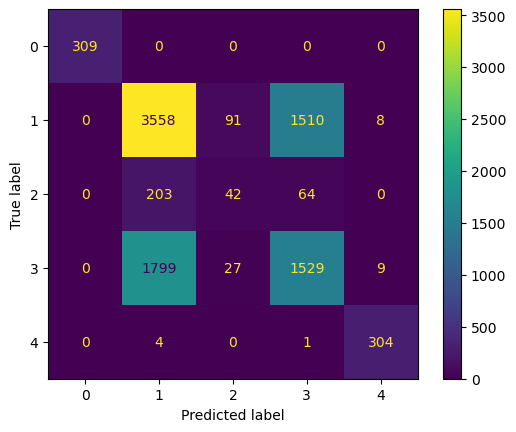

In [18]:

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_predict = [el for lst in all_predict_seq for el in lst]
all_labels = [el for lst in all_labels_seq for el in lst]
#from sklearn.preprocessing import MultiLabelBinarizer

#all_labels = MultiLabelBinarizer().fit_transform(all_labels)
#all_predict = MultiLabelBinarizer().fit_transform(all_predict)

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(all_labels, all_predict, average='macro')
f1_scores = f1_score(all_labels, all_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(all_labels, all_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()


 The F1 scores for each of the classes are: [0.35897436 0.13953488 0.31111111 0.1875     0.19277108 0.23076923
 0.27027027 0.24615385]

 The average F1 score is: 0.24213559816713712



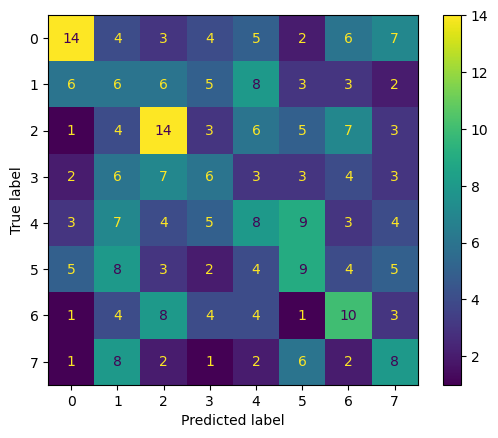

In [19]:

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_predict = all_predict_cls 
all_labels = all_labels_cls
#from sklearn.preprocessing import MultiLabelBinarizer

#all_labels = MultiLabelBinarizer().fit_transform(all_labels)
#all_predict = MultiLabelBinarizer().fit_transform(all_predict)

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(all_labels, all_predict, average='macro')
f1_scores = f1_score(all_labels, all_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(all_labels, all_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

## METHOD 2. MEMM bi-gram NLM

### a. Create Dataset (MEMM)

In [20]:
class MEMMDataset(Dataset):
    def __init__(self, samples, labels):
        self.tokens = [el for i in samples for el in i]
        self.labels = [el for i in labels for el in i]
    
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, idx):
        prev_label = self.labels[idx]
        current_token = self.tokens[idx+1]
        current_label = self.labels[idx+1]
        return prev_label, current_token, current_label


MEMM_train_dataset = MEMMDataset(train_sample_word_lst, train_nobi_idx_lst)
MEMM_test_dataset = MEMMDataset(test_sample_word_lst, test_nobi_idx_lst)


In [21]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, labelset_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim + 1, 128)
        self.linear2 = nn.Linear(128, labelset_size)

    def forward(self, label_ix, token_ix):
        token_lookup_tensor = torch.tensor(token_ix, dtype=torch.long)
        embeds = self.embeddings(token_lookup_tensor).view(1,-1)
        label = torch.tensor(np.array([label_ix]), dtype=torch.long).view(1,-1)
        concat = torch.cat([embeds, label], dim=1)

        out = self.linear1(concat)
        out = torch.relu(out)
        out = self.linear2(out)        
        log_probs = torch.log_softmax(out, dim=1)
        return log_probs

    def get_logprob(self,context,target):
        #return the logprob of the target word given the context
        # context = [LAST LABEL IDX, CURRENT TOKEN IDX]
        log_probs = self.forward(new_label_to_idx[context[0]], word_to_idx[context[1]])
        target_idx=torch.tensor(new_label_to_idx[target],dtype=torch.long)
        return log_probs.index_select(1,target_idx).item()
    
        
    def nextlikely(self,context):
        #sample the distribution of target words given the context
        # context = [LAST LABEL, CURRENT TOKEN]
        #context_idxs = torch.tensor([label_to_ix[context[0]], word_to_ix[context[1]]], dtype=torch.long)
        log_probs = self.forward(new_label_to_idx[context[0]], word_to_idx[context[1]])
        probs=[math.exp(x) for x in log_probs.flatten().tolist()]
        t=random.choices(list(range(len(probs))),weights=probs,k=1)
        return new_idx_to_label[t[0]]
    
    def generate(self,sentence):
        #generate a sequence of tokens according to the model
        labels=random.choices(list(new_label_to_idx.keys()))
        last_label = labels[-1]
        for token in sentence:
            #print(token, last_label)
            current_label = self.nextlikely([last_label, token])
            labels.append(current_label)
            last_label = labels[-1]
        return labels[1:]

    def demo(self, sentence):
        labels = self.generate(sentence)

        # get predicted class
        processed_cls = [int(i[0]) for i in labels]
        predicted_cls = sorted(FreqDist(processed_cls), key=FreqDist(processed_cls).get, reverse=True)[0]

        # get predicted snippet
        predicted_seq = [i[1] for i in labels]
        snippet = [token for token, label in zip(sentence, predicted_seq) if label == "B" or label == "I"]
        joined = " ".join(snippet)

        print(f"Propaganda text = {sentence}")
        print(f"Predicted class = {predicted_cls}\nPredicted snippet = \"{joined}\"")
    
    def train(self,inputngrams,loss_function=nn.NLLLoss(),lr=0.001,epochs=100):
        optimizer=optim.SGD(self.parameters(),lr=lr)
        
        losses=[]
        for epoch in tqdm.tqdm(range(epochs)):
            total_loss = 0
            for last_label_ix, current_token_ix, target in inputngrams:

                self.zero_grad()

                log_probs = self.forward(last_label_ix, current_token_ix)

                loss = loss_function(log_probs, torch.tensor([target], dtype=torch.long))
               

                loss.backward()
                optimizer.step()
            
                total_loss += loss.item()
                
            losses.append(total_loss)
        print(losses)


In [22]:

MEMMmodel = NGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, TAGSET_SIZE)
MEMMmodel.train(MEMM_train_dataset)

100%|█████████████████████████████████████████| 100/100 [10:05<00:00,  6.06s/it]

[67278.85558993183, 47077.70055036992, 41023.1136126779, 37336.068224687595, 34562.558093817206, 32414.84377344814, 30714.470894217608, 29270.18474852934, 28009.18176848418, 26913.88493892888, 25959.821843066602, 25112.460647310014, 24373.719296843512, 23702.83953183936, 23107.234476866317, 22583.062837612582, 22110.979132984066, 21681.651894873474, 21287.30716612062, 20921.817512094625, 20539.593720986624, 20213.17083531327, 19900.145496879006, 19721.573646042263, 19464.36066873721, 19207.84852503531, 18957.026744069764, 18732.139981198823, 18517.48017878947, 18317.29122298537, 18125.650072728982, 17944.677244180813, 17772.31055821583, 17605.626891360153, 17446.488165413204, 17289.69222724618, 17142.114107222296, 16999.699756573595, 16865.402512867644, 16730.578984025284, 16611.64349442121, 16493.00701795763, 16384.07762753853, 16283.604417950672, 16185.5778349631, 16091.70547860241, 16009.539067908161, 15922.184280601039, 15840.376529869536, 15758.486969623045, 15689.648592343729, 15

In [23]:
MEMM_train_dataset[44]

(11, 3899, 11)

In [24]:
MEMMmodel.get_logprob(["0S","his"],"0B")

-0.6876934766769409

In [25]:
MEMMmodel.nextlikely(["0S","his"])

'0O'

In [26]:
sample = train_df_prep["sample_word"].values[0]
#print(sample)
MEMMmodel.generate(sample)

['3S',
 '3O',
 '3O',
 '3I',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3O',
 '3E']

In [27]:
#MEMMmodel.eval()
correct = 0
total = 0
all_predict = []
all_labels = []
with torch.no_grad():
    for last_label_ix, current_token_ix, target in MEMM_test_dataset:
        outputs = MEMMmodel.forward(last_label_ix, current_token_ix)
        _, predicted = torch.max(outputs.data, 1)
        
        translated_p = predicted.tolist()[0]%5 
        translated_t = target%5

        all_predict.append(translated_p)
        all_labels.append(translated_t)


total = len(all_predict)
correct = sum([p == l for p, l in zip(all_predict, all_labels)])

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 83.43%



 The F1 scores for each of the classes are: [1.         0.85646658 0.15384615 0.80729862 1.        ]

 The average F1 score is: 0.7635222705056901



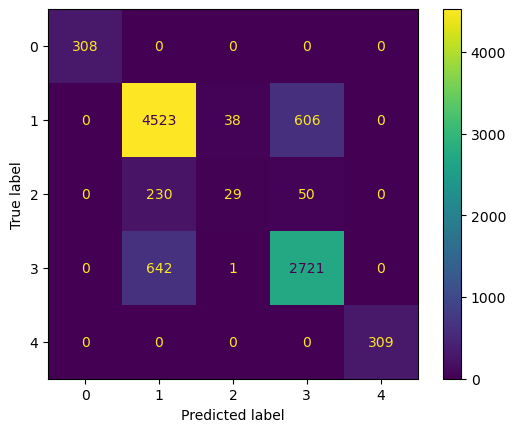

In [28]:

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#all_labels = MultiLabelBinarizer().fit_transform(all_labels)
#all_predict = MultiLabelBinarizer().fit_transform(all_predict)

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(all_labels, all_predict, average='macro')
f1_scores = f1_score(all_labels, all_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(all_labels, all_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

In [29]:
correct = 0
total = 0
all_predict = []
all_labels = []

test_inputs = test_df_prep["sample_word"].values

with torch.no_grad():
    for i, (_, target) in enumerate(test_dataset):
        predict = MEMMmodel.generate(test_inputs[i])

        processed = [int(i[0]) for i in predict]
        translated_p = sorted(FreqDist(processed), key=FreqDist(processed).get, reverse=True)[0]
        translated_t = sorted(FreqDist([i//5 for i in target.tolist()]), key=FreqDist([i//5 for i in target.tolist()]).get, reverse=True)[0]
        
        all_predict.append(translated_p)
        all_labels.append(translated_t)


total = len(all_predict)
correct = sum([p == l for p, l in zip(all_predict, all_labels)])

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 15.21%



 The F1 scores for each of the classes are: [0.1372549  0.10526316 0.08163265 0.10526316 0.2295082  0.16438356
 0.21176471 0.        ]

 The average F1 score is: 0.1293837918823728



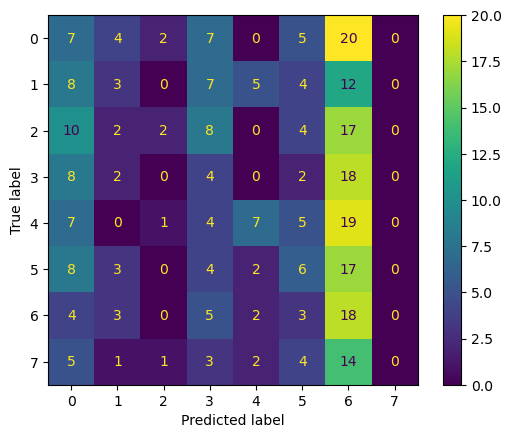

In [30]:

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#all_labels = MultiLabelBinarizer().fit_transform(all_labels)
#all_predict = MultiLabelBinarizer().fit_transform(all_predict)

# F1 score similar to accuracy in that it ranges between 0 and 1
avg_f1_score = f1_score(all_labels, all_predict, average='macro')
f1_scores = f1_score(all_labels, all_predict, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores))
print('\n The average F1 score is: '+str(avg_f1_score))
print()

# Confusion shows the misclassification
confusion_matrix = confusion_matrix(all_labels, all_predict)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()